In [2]:
from PyNite import FEModel3D
from PyNite import Visualization
import numpy as np
from GPyOpt.methods import BayesianOptimization

In [3]:
def Ixx(section, vars):
    """
    return Ixx of sections
    section: "solid circular", "thin circular", "rectangular"
    vars:   vars[0] = r for solid circular
            vars[0] = r and vars[1] = t for thin-walled cirular
             
    """
    if section == "solid circular":
        return(np.pi*vars[0]**4/4)
    elif section == "thin circular":
        return(np.pi*(vars[0]**4 - vars[1]**4)/64)
    elif section == "rectangular":
        return(vars[0]*vars[1]**3/12)
    else:
        print("invalid section")

In [4]:
def J(section, vars):
    """
    return J of sections
    section: "solid circular", "thin circular", "rectangular"
    vars:   vars[0] = r for solid circular
            vars[0] = r and vars[1] = t for thin-walled cirular
            vars[0] = b and vars[1] = h for rectangular
    """
    if section == "solid circular":
        return(np.pi*vars[0]**4/2)
    elif section == "thin circular":
        return(np.pi*(vars[0]**4 - vars[1]**4)/32)
    elif section == "rectangular":
        return(vars[0]*vars[1]*(vars[0]**2+vars[1]**2)/12)
    else:
        print("invalid section")

In [5]:
def area(section, vars):
    """
    return area of sections
    section: "solid circular", "thin circular", "rectangular"
    vars:   vars[0] = r for solid circular
            vars[0] = r and vars[1] = t for thin cirular
            vars[0] = b and vars[1] = h for rectangular 
    """
    if section == "solid circular":
        return(np.pi*vars[0]**2)
    elif section == "thin circular":
        return(np.pi*(vars[1]**2-vars[0]**2))
    elif section == "rectangular":
        return(vars[0]*vars[1])
    else:
        print("invalid section")

In [6]:
def truss(vars, visual = False):
    """
    truss setup taken from PyNite examples
    solid circular cross section
    material properties taken for steel
    """
    r = vars[0]
    
    # Create a new model
    truss = FEModel3D()
    
    #Define the nodes
    truss.AddNode('A', 1.1, -0.4, 0)
    truss.AddNode('B', 1, 0, 0)
    truss.AddNode('C', 0, 0, 0.6)
    truss.AddNode('D', 0, 0, -0.4)
    truss.AddNode('E', 0, 0.8, 0)

    # Define the supports
    truss.DefineSupport('C', True, True, True, True, True, True)
    truss.DefineSupport('D', True, True, True, True, True, True)
    truss.DefineSupport('E', True, True, True, True, True, True)
    

    # Create members
    # using steel
    E = 200*10**9 #Pa
    G = 79.3*10**9 #Pa
    rho = 7850 #kg/m**3
    section = "solid circular"
    detail = {}
    member_names = ['AB','AC','AD','BC','BD','BE']
    weight = 0
    for i, member in enumerate(member_names):
        if len(r) == 1:
            sec_area = area(section, r)
            truss.AddMember(member, member[0], member[1], E, G, Ixx(section, r), Ixx(section, r), J(section, r), sec_area)
        else:
            sec_area = area(section, [r[i]])
            truss.AddMember(member, member[0], member[1], E, G, Ixx(section, [r[i]]), Ixx(section, [r[i]]), J(section, [r[i]]), sec_area)
        weight += truss.GetMember(member).L()*sec_area*rho
        print(weight)
        
    # Release the moments at the ends of the members to make truss members
    truss.DefineReleases('AC', False, False, False, False, True, True, \
                               False, False, False, False, True, True)
    truss.DefineReleases('AD', False, False, False, False, True, True, \
                               False, False, False, False, True, True)
    truss.DefineReleases('BC', False, False, False, False, True, True, \
                               False, False, False, False, True, True)
    truss.DefineReleases('BD', False, False, False, False, True, True, \
                               False, False, False, False, True, True)
    truss.DefineReleases('BE', False, False, False, False, True, True, \
                               False, False, False, False, True, True)

    # Add nodal loads
    truss.AddNodeLoad('A', 'FX', 10)
    truss.AddNodeLoad('A', 'FY', 60)
    truss.AddNodeLoad('A', 'FZ', 20)

    # Analyze the model
    truss.Analyze()
    
    if visual:
        Visualization.RenderModel(truss, deformed_shape=True, text_height=0.05)

    x_deflect = [truss.GetNode(node_name).DX['Combo 1'] for node_name in ['A','B','C','D','E']]
    y_deflect = [truss.GetNode(node_name).DY['Combo 1'] for node_name in ['A','B','C','D','E']]
    z_deflect = [truss.GetNode(node_name).DZ['Combo 1'] for node_name in ['A','B','C','D','E']]

    max_deflect = max(max(x_deflect), max(y_deflect), max(z_deflect))
    print(f"maximum deflection: {max_deflect} m")
    print(f"weight: {weight} kg")
    return(1000 * max_deflect + weight)

In [7]:
r_domain = [{'name': 'r', 'type': 'continuous', 'domain': (0.0001,0.1)}]

Opt_r = BayesianOptimization(truss,
                            domain=r_domain,
                            acquisition_type="EI",
                            model_type='GP',
                            exact_feval=False)
Opt_r.run_optimization(max_iter = 50, max_time = 600, eps=1e-6)

1.5523346868625727
6.504372505937681
11.161376566525398
15.55204210153188
19.60703311250516
24.428540374555205
+-----------+
| Analyzing |
+-----------+

...Analyzing load combination Combo 1
...Adding spring stiffness terms to global stiffness matrix
...Adding member stiffness terms to global stiffness matrix
...Adding quadrilateral stiffness terms to global stiffness matrix
...Adding plate stiffness terms to global stiffness matrix
...Calculating global displacement vector for load combination Combo 1
...Checking for tension/compression-only spring convergence
...Checking for tension/compression-only member convergence
...Tension/compression-only analysis converged after 1 iteration(s)
...Calculating reactions
...Analysis complete

maximum deflection: 3.6303018787056395e-06 m
weight: 24.428540374555205 kg
1.8186640742213709
7.620308108820433
13.076300331484545
18.220259129813687
22.970952736907307
28.619671479906152
+-----------+
| Analyzing |
+-----------+

...Analyzing load combina

101.68197899580927
426.05339823101303
731.0993352184407
1018.69940270806
1284.3119115925456
1600.1332382027117
+-----------+
| Analyzing |
+-----------+

...Analyzing load combination Combo 1
...Adding spring stiffness terms to global stiffness matrix
...Adding member stiffness terms to global stiffness matrix
...Adding quadrilateral stiffness terms to global stiffness matrix
...Adding plate stiffness terms to global stiffness matrix
...Calculating global displacement vector for load combination Combo 1
...Checking for tension/compression-only spring convergence
...Checking for tension/compression-only member convergence
...Tension/compression-only analysis converged after 1 iteration(s)
...Calculating reactions
...Analysis complete

maximum deflection: 5.522679660710643e-08 m
weight: 1600.1332382027117 kg
22.52289986357491
94.3722586800597
161.94095827078442
225.64533917286195
284.4794019949942
354.4348865781111
+-----------+
| Analyzing |
+-----------+

...Analyzing load combination 

16.314638839873332
68.35928438141612
117.30320090103612
163.44796792617157
206.0648819221278
256.73768483626947
+-----------+
| Analyzing |
+-----------+

...Analyzing load combination Combo 1
...Adding spring stiffness terms to global stiffness matrix
...Adding member stiffness terms to global stiffness matrix
...Adding quadrilateral stiffness terms to global stiffness matrix
...Adding plate stiffness terms to global stiffness matrix
...Calculating global displacement vector for load combination Combo 1
...Checking for tension/compression-only spring convergence
...Checking for tension/compression-only member convergence
...Tension/compression-only analysis converged after 1 iteration(s)
...Calculating reactions
...Analysis complete

maximum deflection: 3.4524029392280046e-07 m
weight: 256.73768483626947 kg
80.23341432601869
336.1826664161007
576.8829093941567
803.8172747848675
1013.4020870196941
1262.6047835166876
+-----------+
| Analyzing |
+-----------+

...Analyzing load combinati

0.18127772063276704
0.7595641790404742
1.3033973409387754
1.8161281630886557
2.2896597628632294
2.8527031927857243
+-----------+
| Analyzing |
+-----------+

...Analyzing load combination Combo 1
...Adding spring stiffness terms to global stiffness matrix
...Adding member stiffness terms to global stiffness matrix
...Adding quadrilateral stiffness terms to global stiffness matrix
...Adding plate stiffness terms to global stiffness matrix
...Calculating global displacement vector for load combination Combo 1
...Checking for tension/compression-only spring convergence
...Checking for tension/compression-only member convergence
...Tension/compression-only analysis converged after 1 iteration(s)
...Calculating reactions
...Analysis complete

maximum deflection: 3.108887503416981e-05 m
weight: 2.8527031927857243 kg
53.22163463209436
223.00174050848983
382.6666444047729
533.2001594215197
672.2251080030834
837.529987194728
+-----------+
| Analyzing |
+-----------+

...Analyzing load combinati

0.27819049916370586
1.1656343503027564
2.000205847793874
2.787047401475182
3.5137334589303055
4.377785214845155
+-----------+
| Analyzing |
+-----------+

...Analyzing load combination Combo 1
...Adding spring stiffness terms to global stiffness matrix
...Adding member stiffness terms to global stiffness matrix
...Adding quadrilateral stiffness terms to global stiffness matrix
...Adding plate stiffness terms to global stiffness matrix
...Calculating global displacement vector for load combination Combo 1
...Checking for tension/compression-only spring convergence
...Checking for tension/compression-only member convergence
...Tension/compression-only analysis converged after 1 iteration(s)
...Calculating reactions
...Analysis complete

maximum deflection: 2.0258423077543236e-05 m
weight: 4.377785214845155 kg
0.2831725064373385
1.18650925016117
2.0360267694731857
2.8369595676629187
3.5766595678471163
4.456185296258164
+-----------+
| Analyzing |
+-----------+

...Analyzing load combinati

0.2101040588305317
0.8803482104785354
1.5106603869701305
2.1049244059856758
2.653755838496358
3.3063330526826955
+-----------+
| Analyzing |
+-----------+

...Analyzing load combination Combo 1
...Adding spring stiffness terms to global stiffness matrix
...Adding member stiffness terms to global stiffness matrix
...Adding quadrilateral stiffness terms to global stiffness matrix
...Adding plate stiffness terms to global stiffness matrix
...Calculating global displacement vector for load combination Combo 1
...Checking for tension/compression-only spring convergence
...Checking for tension/compression-only member convergence
...Tension/compression-only analysis converged after 1 iteration(s)
...Calculating reactions
...Analysis complete

maximum deflection: 2.6823444592247854e-05 m
weight: 3.3063330526826955 kg


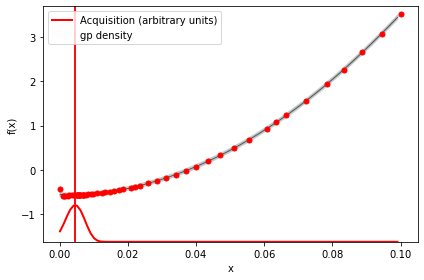

In [8]:
Opt_r.plot_acquisition()

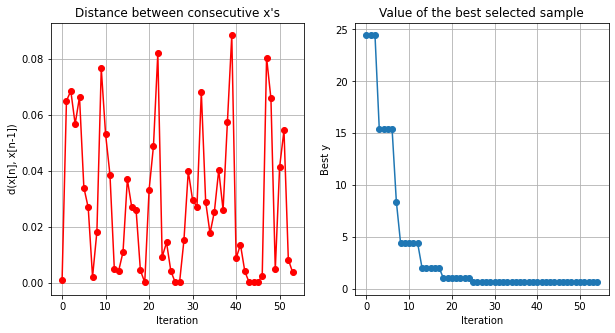

In [9]:
Opt_r.plot_convergence()

In [10]:
print(Opt_r.x_opt)

[0.00124901]


In [ ]:
truss([Opt_r.x_opt], True)

In [83]:
rs_domain = [{'name': 'r', 'type': 'continuous', 'domain': (0.0001,0.1)}]*6

Opt_rs = BayesianOptimization(truss,
                            domain=rs_domain,
                            acquisition_type="EI",
                            model_type='GP',
                            exact_feval=False)
Opt_rs.run_optimization(max_iter = 100, max_time = 600, eps=1e-6)

81.45443436111175
293.7196473132159
373.19147681525453
391.35341869819865
396.51679875618333
481.52000785293
+-----------+
| Analyzing |
+-----------+

...Analyzing load combination Combo 1
...Adding spring stiffness terms to global stiffness matrix
...Adding member stiffness terms to global stiffness matrix
...Adding quadrilateral stiffness terms to global stiffness matrix
...Adding plate stiffness terms to global stiffness matrix
...Calculating global displacement vector for load combination Combo 1
...Checking for tension/compression-only spring convergence
...Checking for tension/compression-only member convergence
...Tension/compression-only analysis converged after 1 iteration(s)
...Calculating reactions
...Analysis complete

maximum deflection: 5.10467301656444e-07 m
weight: 481.52000785293 kg
8.515513661301624
35.91277770959794
38.4646273738453
256.92886983648305
258.90760247585604
465.5187374414709
+-----------+
| Analyzing |
+-----------+

...Analyzing load combination Combo 

0.00010168197899580927
0.000426053398231013
0.0007310993352184408
32.40413405925389
52.335014562659424
52.33533038398603
+-----------+
| Analyzing |
+-----------+

...Analyzing load combination Combo 1
...Adding spring stiffness terms to global stiffness matrix
...Adding member stiffness terms to global stiffness matrix
...Adding quadrilateral stiffness terms to global stiffness matrix
...Adding plate stiffness terms to global stiffness matrix
...Calculating global displacement vector for load combination Combo 1
...Checking for tension/compression-only spring convergence
...Checking for tension/compression-only member convergence
...Tension/compression-only analysis converged after 1 iteration(s)
...Calculating reactions
...Analysis complete

maximum deflection: 0.04680368765805189 m
weight: 52.33533038398603 kg
0.00010168197899580927
0.000426053398231013
0.0007310993352184408
0.0010186994027080601
10.965067740570507
80.18514355227975
+-----------+
| Analyzing |
+-----------+

...Anal

101.68197899580927
101.68230336722851
135.62305407394012
135.6233416740076
165.65555842219015
165.65587424351676
+-----------+
| Analyzing |
+-----------+

...Analyzing load combination Combo 1
...Adding spring stiffness terms to global stiffness matrix
...Adding member stiffness terms to global stiffness matrix
...Adding quadrilateral stiffness terms to global stiffness matrix
...Adding plate stiffness terms to global stiffness matrix
...Calculating global displacement vector for load combination Combo 1
...Checking for tension/compression-only spring convergence
...Checking for tension/compression-only member convergence
...Tension/compression-only analysis converged after 1 iteration(s)
...Calculating reactions
...Analysis complete

maximum deflection: 0.04308833018470163 m
weight: 165.65587424351676 kg
0.00010168197899580927
0.000426053398231013
1.2948592176217428
1.2951468176892325
1.3600174998933894
5.809560037269252
+-----------+
| Analyzing |
+-----------+

...Analyzing load co

101.68197899580927
426.05339823101303
731.0993352184407
731.0996228185082
996.7121317029939
996.7124475243205
+-----------+
| Analyzing |
+-----------+

...Analyzing load combination Combo 1
...Adding spring stiffness terms to global stiffness matrix
...Adding member stiffness terms to global stiffness matrix
...Adding quadrilateral stiffness terms to global stiffness matrix
...Adding plate stiffness terms to global stiffness matrix
...Calculating global displacement vector for load combination Combo 1
...Checking for tension/compression-only spring convergence
...Checking for tension/compression-only member convergence
...Tension/compression-only analysis converged after 1 iteration(s)
...Calculating reactions
...Analysis complete

maximum deflection: 4.8384260161646515e-05 m
weight: 996.7124475243205 kg
10.44012733155587
15.78859669174286
28.657546449956264
35.52064924490672
38.82314538673486
40.40931420384412
+-----------+
| Analyzing |
+-----------+

...Analyzing load combination C

32.76048534693991
32.884237778465305
37.49578073345163
91.74553552474731
109.43449109962107
114.20844218643855
+-----------+
| Analyzing |
+-----------+

...Analyzing load combination Combo 1
...Adding spring stiffness terms to global stiffness matrix
...Adding member stiffness terms to global stiffness matrix
...Adding quadrilateral stiffness terms to global stiffness matrix
...Adding plate stiffness terms to global stiffness matrix
...Calculating global displacement vector for load combination Combo 1
...Checking for tension/compression-only spring convergence
...Checking for tension/compression-only member convergence
...Tension/compression-only analysis converged after 1 iteration(s)
...Calculating reactions
...Analysis complete

maximum deflection: 9.438793354644829e-06 m
weight: 114.20844218643855 kg
95.7354108461234
200.1490999128215
202.9509016076688
487.9010335332624
580.9554442458672
598.7787085032883
+-----------+
| Analyzing |
+-----------+

...Analyzing load combination Co

13.17923897322244
205.43674708072456
205.93554310712608
205.9460079542299
206.29069117509314
501.32008463291425
+-----------+
| Analyzing |
+-----------+

...Analyzing load combination Combo 1
...Adding spring stiffness terms to global stiffness matrix
...Adding member stiffness terms to global stiffness matrix
...Adding quadrilateral stiffness terms to global stiffness matrix
...Adding plate stiffness terms to global stiffness matrix
...Calculating global displacement vector for load combination Combo 1
...Checking for tension/compression-only spring convergence
...Checking for tension/compression-only member convergence
...Tension/compression-only analysis converged after 1 iteration(s)
...Calculating reactions
...Analysis complete

maximum deflection: 5.30225481132713e-05 m
weight: 501.32008463291425 kg
1.6820741169461961
14.055533698910743
21.054583843540215
28.514064866823205
35.77747447021195
49.0896761855178
+-----------+
| Analyzing |
+-----------+

...Analyzing load combinatio

0.00010168197899580927
0.000426053398231013
1.51022357485719
2.0203427397651224
2.114641272747814
8.514391788937347
+-----------+
| Analyzing |
+-----------+

...Analyzing load combination Combo 1
...Adding spring stiffness terms to global stiffness matrix
...Adding member stiffness terms to global stiffness matrix
...Adding quadrilateral stiffness terms to global stiffness matrix
...Adding plate stiffness terms to global stiffness matrix
...Calculating global displacement vector for load combination Combo 1
...Checking for tension/compression-only spring convergence
...Checking for tension/compression-only member convergence
...Tension/compression-only analysis converged after 1 iteration(s)
...Calculating reactions
...Analysis complete

maximum deflection: 0.005026071965032791 m
weight: 8.514391788937347 kg
43.264764812515075
51.21771235863936
53.50387711495581
55.42287984626289
90.87877944212113
92.50796686261941
+-----------+
| Analyzing |
+-----------+

...Analyzing load combinati

8.098584856540235
24.664156490640554
24.950591860145583
35.241033551867076
49.71522086698042
54.008327888514636
+-----------+
| Analyzing |
+-----------+

...Analyzing load combination Combo 1
...Adding spring stiffness terms to global stiffness matrix
...Adding member stiffness terms to global stiffness matrix
...Adding quadrilateral stiffness terms to global stiffness matrix
...Adding plate stiffness terms to global stiffness matrix
...Calculating global displacement vector for load combination Combo 1
...Checking for tension/compression-only spring convergence
...Checking for tension/compression-only member convergence
...Tension/compression-only analysis converged after 1 iteration(s)
...Calculating reactions
...Analysis complete

maximum deflection: 1.1085357382317392e-05 m
weight: 54.008327888514636 kg
0.11824596250044782
73.83624257287376
90.09455299272254
115.6874987295606
141.91430682893872
145.90237052719604
+-----------+
| Analyzing |
+-----------+

...Analyzing load combina

32.72462730787432
307.7806468016693
307.9713784817906
346.9531183832935
358.7377735938309
361.03522687816053
+-----------+
| Analyzing |
+-----------+

...Analyzing load combination Combo 1
...Adding spring stiffness terms to global stiffness matrix
...Adding member stiffness terms to global stiffness matrix
...Adding quadrilateral stiffness terms to global stiffness matrix
...Adding plate stiffness terms to global stiffness matrix
...Calculating global displacement vector for load combination Combo 1
...Checking for tension/compression-only spring convergence
...Checking for tension/compression-only member convergence
...Tension/compression-only analysis converged after 1 iteration(s)
...Calculating reactions
...Analysis complete

maximum deflection: 1.2953276120322802e-05 m
weight: 361.03522687816053 kg
93.30857792685939
94.71406516008692
123.62065579102773
158.0254214393184
158.7578972028469
197.8076304795258
+-----------+
| Analyzing |
+-----------+

...Analyzing load combination C

0.03993744567012246
0.05627322546653288
0.875676440253757
1.7576235657927026
2.0667860573786014
8.46946860084569
+-----------+
| Analyzing |
+-----------+

...Analyzing load combination Combo 1
...Adding spring stiffness terms to global stiffness matrix
...Adding member stiffness terms to global stiffness matrix
...Adding quadrilateral stiffness terms to global stiffness matrix
...Adding plate stiffness terms to global stiffness matrix
...Calculating global displacement vector for load combination Combo 1
...Checking for tension/compression-only spring convergence
...Checking for tension/compression-only member convergence
...Tension/compression-only analysis converged after 1 iteration(s)
...Calculating reactions
...Analysis complete

maximum deflection: 7.57828465115352e-05 m
weight: 8.46946860084569 kg
3.3418958323372725
21.74127297734769
24.248288004780548
43.77043016724102
66.03212099027564
66.54896010864535
+-----------+
| Analyzing |
+-----------+

...Analyzing load combination 

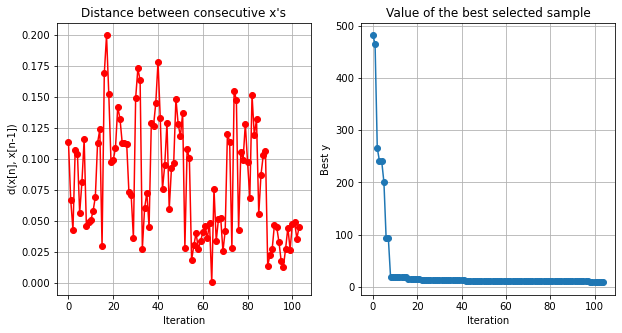

In [84]:
Opt_rs.plot_convergence()

In [85]:
print(Opt_rs.x_opt)

[0.00198184 0.00070966 0.00518282 0.00553767 0.00341169 0.01423837]


In [86]:
truss([Opt_rs.x_opt], True)

0.03993744567012246
0.05627322546653288
0.875676440253757
1.7576235657927026
2.0667860573786014
8.46946860084569
+-----------+
| Analyzing |
+-----------+

...Analyzing load combination Combo 1
...Adding spring stiffness terms to global stiffness matrix
...Adding member stiffness terms to global stiffness matrix
...Adding quadrilateral stiffness terms to global stiffness matrix
...Adding plate stiffness terms to global stiffness matrix
...Calculating global displacement vector for load combination Combo 1
...Checking for tension/compression-only spring convergence
...Checking for tension/compression-only member convergence
...Tension/compression-only analysis converged after 1 iteration(s)
...Calculating reactions
...Analysis complete

maximum deflection: 7.57828465115352e-05 m
weight: 8.46946860084569 kg


8.545251447357225